# Using Autobounds to handle a model without latent confounders

In [9]:
from autobounds.causalProblem import causalProblem
from autobounds.DAG import DAG
from autobounds.Query import Query
import io
from copy import deepcopy

import networkx as nx
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.simplefilter(action='ignore')

## Creating the model

### Setting the DAG

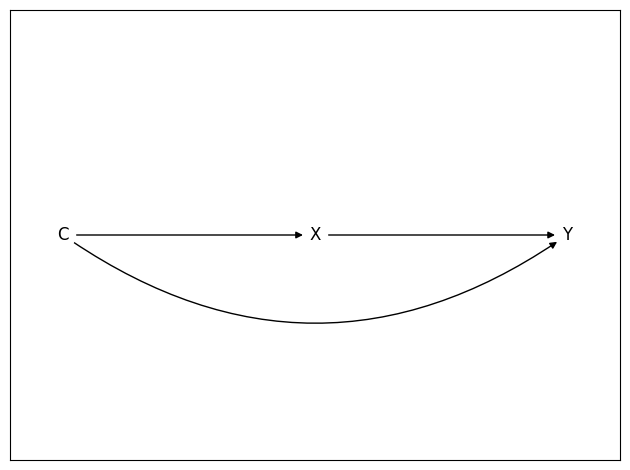

In [10]:
dag_just = DAG()
dag_just.from_structure(edges="C -> X, X -> Y, C -> Y", unob='')
dag_just.plot()

### Generating the data

In [11]:
# Number of data points to generate
num_samples = 1000

# Determine the counts based on the probabilities given
counts = {
    (0, 0): int(num_samples * 0.5 * 0.7 * 0.8),  # P(C=0, X=0, Y=0)
    (0, 1): int(num_samples * 0.5 * 0.7 * 0.2),  # P(C=0, X=0, Y=1)
    (1, 0): int(num_samples * 0.5 * 0.3 * 0.6),  # P(C=0, X=1, Y=1)
    (1, 1): int(num_samples * 0.5 * 0.3 * 0.4),  # P(C=0, X=1, Y=0)
    (2, 0): int(num_samples * 0.5 * 0.3 * 0.4),  # P(C=1, X=0, Y=0)
    (2, 1): int(num_samples * 0.5 * 0.3 * 0.6),  # P(C=1, X=0, Y=1)
    (3, 0): int(num_samples * 0.5 * 0.7 * 0.2),  # P(C=1, X=1, Y=0)
    (3, 1): int(num_samples * 0.5 * 0.7 * 0.8),  # P(C=1, X=1, Y=1)
}

# Adjust counts to ensure the sum matches the total number of samples
adjustment = num_samples - sum(counts.values())
counts[(0, 0)] += adjustment  # Adjust one cell to match the total

# Generate the data based on the counts
data = []
for (key, count) in counts.items():
    C_value = key[0] // 2  # Maps (0, 1) -> C=0 and (2, 3) -> C=1
    X_value = key[0] % 2   # Maps (0, 2) -> X=0 and (1, 3) -> X=1
    Y_value = key[1]
    data.extend([(C_value, X_value, Y_value)] * count)

# Convert the list of tuples into a DataFrame
data = pd.DataFrame(data, columns=['C', 'X', 'Y'])

# Shuffle the data to randomize the order
data = data.sample(frac=1).reset_index(drop=True)

# Display the first few rows of the dataset
print(data.head())

# Verify the empirical probabilities
print("\nEmpirical probabilities:")
print("P(C=0):", np.mean(data['C'] == 0))
print("P(C=1):", np.mean(data['C'] == 1))
print("P(X=1 | C=0):", np.mean(data[data['C'] == 0]['X'] == 1))
print("P(X=1 | C=1):", np.mean(data[data['C'] == 1]['X'] == 1))
print("P(Y=1 | X=0, C=0):", np.mean(data[(data['X'] == 0) & (data['C'] == 0)]['Y'] == 1))
print("P(Y=1 | X=1, C=0):", np.mean(data[(data['X'] == 1) & (data['C'] == 0)]['Y'] == 1))
print("P(Y=1 | X=0, C=1):", np.mean(data[(data['X'] == 0) & (data['C'] == 1)]['Y'] == 1))
print("P(Y=1 | X=1, C=1):", np.mean(data[(data['X'] == 1) & (data['C'] == 1)]['Y'] == 1))


   C  X  Y
0  0  0  0
1  0  1  0
2  0  0  0
3  0  0  0
4  1  1  1

Empirical probabilities:
P(C=0): 0.5
P(C=1): 0.5
P(X=1 | C=0): 0.3
P(X=1 | C=1): 0.7
P(Y=1 | X=0, C=0): 0.2
P(Y=1 | X=1, C=0): 0.4
P(Y=1 | X=0, C=1): 0.6
P(Y=1 | X=1, C=1): 0.8


### Computing probabilities for each strata of the population

Since we have 3 binary observable variables, we have 8 ($2^3$) possible strata for our population. In the Data Frame below, we will calculate the empirical probability for each of them, i.e., $P(C=c, X=x, Y=y)$.

In [12]:
# group individuals into strata
dat = pd.DataFrame(data.groupby(['C', 'X', 'Y']).value_counts().reset_index()) 
dat['prob'] = dat['count'] / dat['count'].sum()
dat = dat.drop(columns='count', axis=0)
dat

,C,X,Y,prob
0,0,0,0,0.28
1,0,0,1,0.07
2,0,1,0,0.09
3,0,1,1,0.06
4,1,0,0,0.06
5,1,0,1,0.09
6,1,1,0,0.07
7,1,1,1,0.28


### Defining the problem

In [13]:
problem_just = causalProblem(dag_just)
problem_just.load_data(dat)

### Adding the constraints for the optimization problem

In [14]:
problem_just.add_prob_constraints()

## Calculating the ATE

In [15]:
problem_just.set_ate(ind="X", dep="Y")
just_prog_ate = problem_just.write_program()


# run optimisation routine, argument saves results at filename
just_prog_ate_optim = just_prog_ate.run_scip('replication_files/results/Identifiable.csv')

print("==============================================")
print(f"Causal effect lies in the interval [{np.round(just_prog_ate_optim[0]['dual'], 3)}, "
      f"{np.round(just_prog_ate_optim[1]['dual'], 3)}]" 
)

[('C0', 0.5), ('C1', 0.5)]


LOWER BOUND: # -- Primal: 0.2 / Dual: 0.02439587 / Time: d 0.5 ##
UPPER BOUND: # -- Primal: 0.2 / Dual: 0.5497454 / Time: 0.3 ##
CURRENT THRESHOLDS: # -- Theta: 0.5253495300000001 / Epsilon: 99999999 ##
LOWER BOUND: # -- Primal: 0.2 / Dual: 0.1870764 / Time: 5.4 ##
UPPER BOUND: # -- Primal: 0.2 / Dual: 0.2142446 / Time: 5.4 ##
CURRENT THRESHOLDS: # -- Theta: 0.027168200000000003 / Epsilon: 99999999 ##
LOWER BOUND: # -- Primal: 0.2 / Dual: 0.1902069 / Time: 10.4 ##
UPPER BOUND: # -- Primal: 0.2 / Dual: 0.2107869 / Time: 10.4 ##
CURRENT THRESHOLDS: # -- Theta: 0.020579999999999987 / Epsilon: 99999999 ##
LOWER BOUND: # -- Primal: 0.2 / Dual: 0.191316 / Time: 15.4 ##
UPPER BOUND: # -- Primal: 0.2 / Dual: 0.2095961 / Time: 15.4 ##
CURRENT THRESHOLDS: # -- Theta: 0.018280099999999994 / Epsilon: 99999999 ##
LOWER BOUND: # -- Primal: 0.2 / Dual: 0.1920257 / Time: 20.5 ##
UPPER BOUND: # -- Primal: 0.2000001 / Dual: 0.2087882 / Time: 20.5 ##
CURRENT THRESHOLDS: # -- Theta: 0.016762500000000014 /

In [16]:
just_prog_ate.plot()

IndexError: list index out of range

## Conclusion 

The result we were looking for was $0.2$, considering that
$$ \mathbb{P}(Y=y | do(X=x)) = \sum_c \mathbb{P}(Y = y | X=x, C=c)\mathbb{P}(C=c) $$
we get
$$ \mathbb{P}(Y=1 | do(X=1)) = \mathbb{P}(Y = 1 | X=1, C=1)\mathbb{P}(C=1) + \mathbb{P}(Y = 1 | X=1, C=0)\mathbb{P}(C=0) = (0.8)(0.5) + (0.4)(0.5) = 0.6 $$
$$ \mathbb{P}(Y=1 | do(X=0)) = \mathbb{P}(Y = 1 | X=0, C=1)\mathbb{P}(C=1) + \mathbb{P}(Y = 1 | X=0, C=0)\mathbb{P}(C=0) = (0.6)(0.5) + (0.2)(0.5) = 0.4 $$
Now, to calculate the ATE:
$$ ATE = \mathbb{P}(Y=1 | do(X=1)) - \mathbb{P}(Y=1 | do(X=0)) = 0.6 - 0.4 = 0.2 $$

It is possible to conclude that Autobounds is **not the best tool** for completely identifiable models. 

In this case, we believe the algorithm would be able to find the actual ATE, but its execution **inexplicably stops** before doing so. We are able to suppose that since its theta is still far from zero when the results are given. Moreover, we normally also get a summary of the execution at the end of the log file when it's done, but it's missing in this example, which makes it impossible to plot the graph afterward.

Even if the program actually returned accurate results after running for a longer period of time, it's still not ideal considering other tools like DoWhy usually take less than a second to solve such a simple problem.